In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from collections import deque
import matplotlib.pyplot as plt
import glfw

observation = val_env.step(val_env.action_space.sample())[0]

reward = val_env.step(val_env.action_space.sample())[1]

terminated = val_env.step(val_env.action_space.sample())[2] # bool

truncated = val_env.step(val_env.action_space.sample())[3] # bool

info = val_env.step(val_env.action_space.sample())[4] # dict

dict_keys(['reward_linvel', 'reward_quadctrl', 'reward_alive', 'x_position', 'y_position', 'distance_from_origin', 'x_velocity', 'y_velocity', 'forward_reward'])

### Actor

In [95]:
class Actor(nn.Module) :
    def __init__(self, input_size, hidden_size, n_actions, init_weight, min_act_value, lr, device=torch.device('cpu')):
        super(Actor, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_actions = n_actions
        self.init_weight = init_weight
        self.min_act_value = min_act_value
        self.lr = lr
        self.device = device

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.fc1 = nn.Linear(
            in_features=self.input_size,
            out_features=self.hidden_size
        )

        self.fc2 = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.hidden_size
        )

        self.mean_fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features=self.n_actions
        )

        self.mean_fc3.weight.data.uniform_(-self.init_weight, self.init_weight)
        self.mean_fc3.bias.data.uniform_(-self.init_weight, self.init_weight)

        self.log_std_fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features=self.n_actions
        )

        self.log_std_fc3.weight.data.uniform_(-self.init_weight, self.init_weight)
        self.log_std_fc3.bias.data.uniform_(-self.init_weight, self.init_weight)

        self.optimizer = optim.Adam(params=self.parameters(), lr=self.lr, weight_decay=0.2)

    def forward(self, x):

        x = x.float() # from float64 to float32

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))

        return self.mean_fc3(x), self.log_std_fc3(x)   # mean, log_std
    
    def act(self, state, greedy=False):

        mean, log_std = self.forward(state)
        #   print('Mean: ', mean)
        #   print('Log_Std: ', log_std)

        # multiply by 0.4 in ordert to scale and shift output of tanh to an interval [-0.4 ; 0.4]
        action = self.min_act_value * self.tanh(mean)

        log_prob = None

        if not greedy: # explore
            
            # Apply Reparameterization Trick

            gaussian = Normal(0, 1)
            z = gaussian.sample()
            std = log_std.exp()
            # multiply by 0.4 in ordert to scale and shift output of tanh to an interval [-0.4 ; 0.4]
            action = self.min_act_value * self.tanh(mean + std*z)

            log_prob = Normal(mean, std).log_prob(mean + std*z.to(self.device)+ 1e-8)# ?
        
        return action, log_prob


### Critic

In [88]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, init_weight, lr, device=torch.device('cpu')):
        super(Critic, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.init_weight = init_weight
        self.lr = lr
        self.device = device

        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(
            in_features=self.input_size,
            out_features=self.hidden_size
        )

        self.fc2 = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.hidden_size
        )

        self.fc3 = nn.Linear(
            in_features= self.hidden_size,
            out_features= 1
        )

        self.fc3.weight.data.uniform_(-self.init_weight, self.init_weight)
        self.fc3.bias.data.uniform_(-self.init_weight, self.init_weight)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        self.criterion = nn.MSELoss()

    def forward(self, x):

        x = x.float() # from float64 to float32

        x = self.relu(self.fc1(x))

        x = self.relu(self.fc2(x))

        return self.fc3(x)

### Algorithm

In [182]:
class Actor_Critic(nn.Module):
    def __init__(self, input_size, hidden_size, n_actions, init_weight, min_act_value, act_lr, crt_lr, num_episodes, gamma, device=torch.device('cpu')):
        super(Actor_Critic, self).__init__()
        self.device = device

        self.num_episodes = num_episodes
        self.gamma = gamma

        self.Actor = Actor(
            input_size= input_size,
            hidden_size= hidden_size,
            n_actions= n_actions,
            init_weight= init_weight,
            min_act_value= min_act_value,
            lr= act_lr,
            device= self.device
        )

        self.Critic = Critic(
            input_size= input_size,
            hidden_size= hidden_size,
            init_weight= init_weight,
            lr= crt_lr,
            device= self.device
        )

    def save(self, model_name):
        torch.save(self.state_dict(), model_name + '.pt')

    def load(self, model_name):
        self.load_state_dict(torch.load(model_name + '.pt', map_location=self.device))

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret


    def train(self):

        E = gym.make(
            id='Humanoid-v4',            
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
            forward_reward_weight=10,
        )

        scores = deque(maxlen=100)
        act_losses = deque()
        crt_losses = deque()

        for iter in range(self.num_episodes):

        # CONTAINERS

            Rewards = []
            Log_prob = []
            Values = []
            obs_next = E.reset()[0]
            done_next = False

            for param_group in self.Actor.optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * (1 - (iter*0.001/self.num_episodes))
                #   print(param_group['lr'])

        # ROLLOUT
            t = 0

            while not done_next:

            #obs = torch.from_numpy(obs_next)
            #done = done_next

                action, log_prob = self.Actor.act(torch.from_numpy(obs_next))

                # print(action)

                obs_next, reward, done, truncated, info = E.step(action.detach().numpy())

                #   print(f'''
                #       Num_Rollout, Iteration: {t, iter}\n              
                #       Reward: {reward}\n  
                #       Z-torso (healthy in (1.0,2.0)): {obs_next[2]}\n
                #       X_position: {info['x_position']}\n
                #       Y_position: {info['y_position']}\n
                #       Distance_from_Origin: {info['distance_from_origin']}\n
                #       Forward_Reward: {info['forward_reward']}\n
                #       \n''')

                value = self.Critic.forward(torch.from_numpy(obs_next))
                
                Log_prob.append(log_prob)
                Values.append(value)
                Rewards.append(reward)

                done_next = done | truncated

                    # check if z-coordinate of torso is inside the healthy_range

                    # 'reward_alive', 'x_position', 'y_position', 'distance_from_origin', 'x_velocity', 'y_velocity', 'forward_reward'

                t+=1 # update counter

            scores.append(sum(Rewards))

            #   print('Mean Score: ',np.mean(scores))

        # LEARNING

            #print(Log_prob)
            #print(t)

            Log_prob = torch.stack(Log_prob)
            Values = torch.stack(Values).squeeze()

            # compute Advantage
            Vnext = self.Critic.forward(torch.from_numpy(obs_next))
            Advantage = torch.zeros(t)
            Return = torch.zeros(t)

            for a in reversed(range(t)):
                if a == t-1:
                    Return[a] = Rewards[a] + self.gamma*Vnext
                else:
                    Return[a] = Rewards[a] + self.gamma*Values[a+1]
                    
            Advantage = Return - Values
            
            actor_loss = - (Log_prob.T @ Advantage.detach()).mean()
            critic_loss = self.Critic.criterion(Values, Advantage)

            act_losses.append(actor_loss.item())
            print('Actor Loss: ', actor_loss)
            crt_losses.append(critic_loss.item())
            print('Critic Loss: ', critic_loss)

        # UPDATES

            # Actor
            self.Actor.optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            self.Actor.optimizer.step()

            # Critic
            self.Critic.optimizer.zero_grad()
            critic_loss.backward()
            self.Critic.optimizer.step()

        # SAVE


            if iter % 10 == 0:

                print(f'''Episode {iter}
                    \tAverage Score: {np.mean(scores)}
                    \tAverage Actor Loss: {np.mean(act_losses)}
                    \tAverage Critic Loss: {np.mean(crt_losses)}
                    \tLast Score: {sum(Rewards)}\n''')
                
            if iter % 1000 == 0:
                model_name = 'model_' + str((iter % self.num_episodes) // 1000)
                self.save(model_name)

        return act_losses, crt_losses

### Evaluation

In [203]:
def Evaluate_Humanoid(agent, n_eval_episodes):
    rewards = []

    agent.load('final')

    val_env = gym.make(
        id='Humanoid-v4',
        forward_reward_weight = 10,
        terminate_when_unhealthy = True,
        exclude_current_positions_from_observation=False,
        render_mode = 'human',
    )

    for n_episode in range(n_eval_episodes):
        episode_rewards = 0
        obs = val_env.reset()[0]
        done = False

        while not done:
            
            action, _ = agent.Actor.act(torch.from_numpy(obs))
            #print(action)
            obs_next, rew, terminated, truncated, info = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = truncated #terminated | truncated
            episode_rewards += rew
            obs = obs_next

        print('Reward episode %d: %d' %(n_episode, episode_rewards))

        rewards.append(episode_rewards)

    print('Mean Reward: ', np.mean(rewards))
    glfw.terminate() # close Mujoco render

In [210]:
def Previous_Episodes(agent):

    val_env = gym.make(
        id='Humanoid-v4',
        forward_reward_weight = 10,
        terminate_when_unhealthy = True,
        exclude_current_positions_from_observation=False,
        render_mode = 'human',
    )
    num = agent.num_episodes // 1000
    print(num)
    for n_model in range(num):
        agent.load('model_'+str(n_model))

        episode_rewards = 0
        obs = val_env.reset()[0]
        done = False

        while not done:
            
            action, _ = agent.Actor.act(torch.from_numpy(obs))
            #print(action)
            obs_next, rew, terminated, truncated, info = val_env.step(action.detach().numpy())
            #print(obs_next[0])
            done = terminated | truncated
            episode_rewards += rew
            obs = obs_next

        print('Reward at %d: %d' %(n_model*1000, episode_rewards))
        
    glfw.terminate() # close Mujoco render

### Training and Testing

In [184]:
agent = Actor_Critic(
    input_size= 378,
    hidden_size= 32,
    n_actions= 17,
    init_weight= 3e-3,
    min_act_value= 4e-1,
    act_lr= 1e-4,
    crt_lr= 1e-4,
    num_episodes= 10000,
    gamma=0.9
)

act_losses, crt_losses = agent.train()
agent.save('final')

Actor Loss:  tensor(98.5022, grad_fn=<NegBackward0>)
Critic Loss:  tensor(23.9308, grad_fn=<MseLossBackward0>)
Episode 0
                    	Average Score: 78.2440966677088
                    	Average Actor Loss: 98.50218200683594
                    	Average Critic Loss: 23.930789947509766
                    	Last Score: 78.2440966677088

Actor Loss:  tensor(94.3652, grad_fn=<NegBackward0>)
Critic Loss:  tensor(24.9266, grad_fn=<MseLossBackward0>)
Actor Loss:  tensor(154.4644, grad_fn=<NegBackward0>)
Critic Loss:  tensor(38.7294, grad_fn=<MseLossBackward0>)
Actor Loss:  tensor(142.4388, grad_fn=<NegBackward0>)
Critic Loss:  tensor(24.9891, grad_fn=<MseLossBackward0>)
Actor Loss:  tensor(128.5297, grad_fn=<NegBackward0>)
Critic Loss:  tensor(41.6198, grad_fn=<MseLossBackward0>)
Actor Loss:  tensor(134.8228, grad_fn=<NegBackward0>)
Critic Loss:  tensor(26.8182, grad_fn=<MseLossBackward0>)
Actor Loss:  tensor(116.6519, grad_fn=<NegBackward0>)
Critic Loss:  tensor(22.6575, grad_fn=<Mse

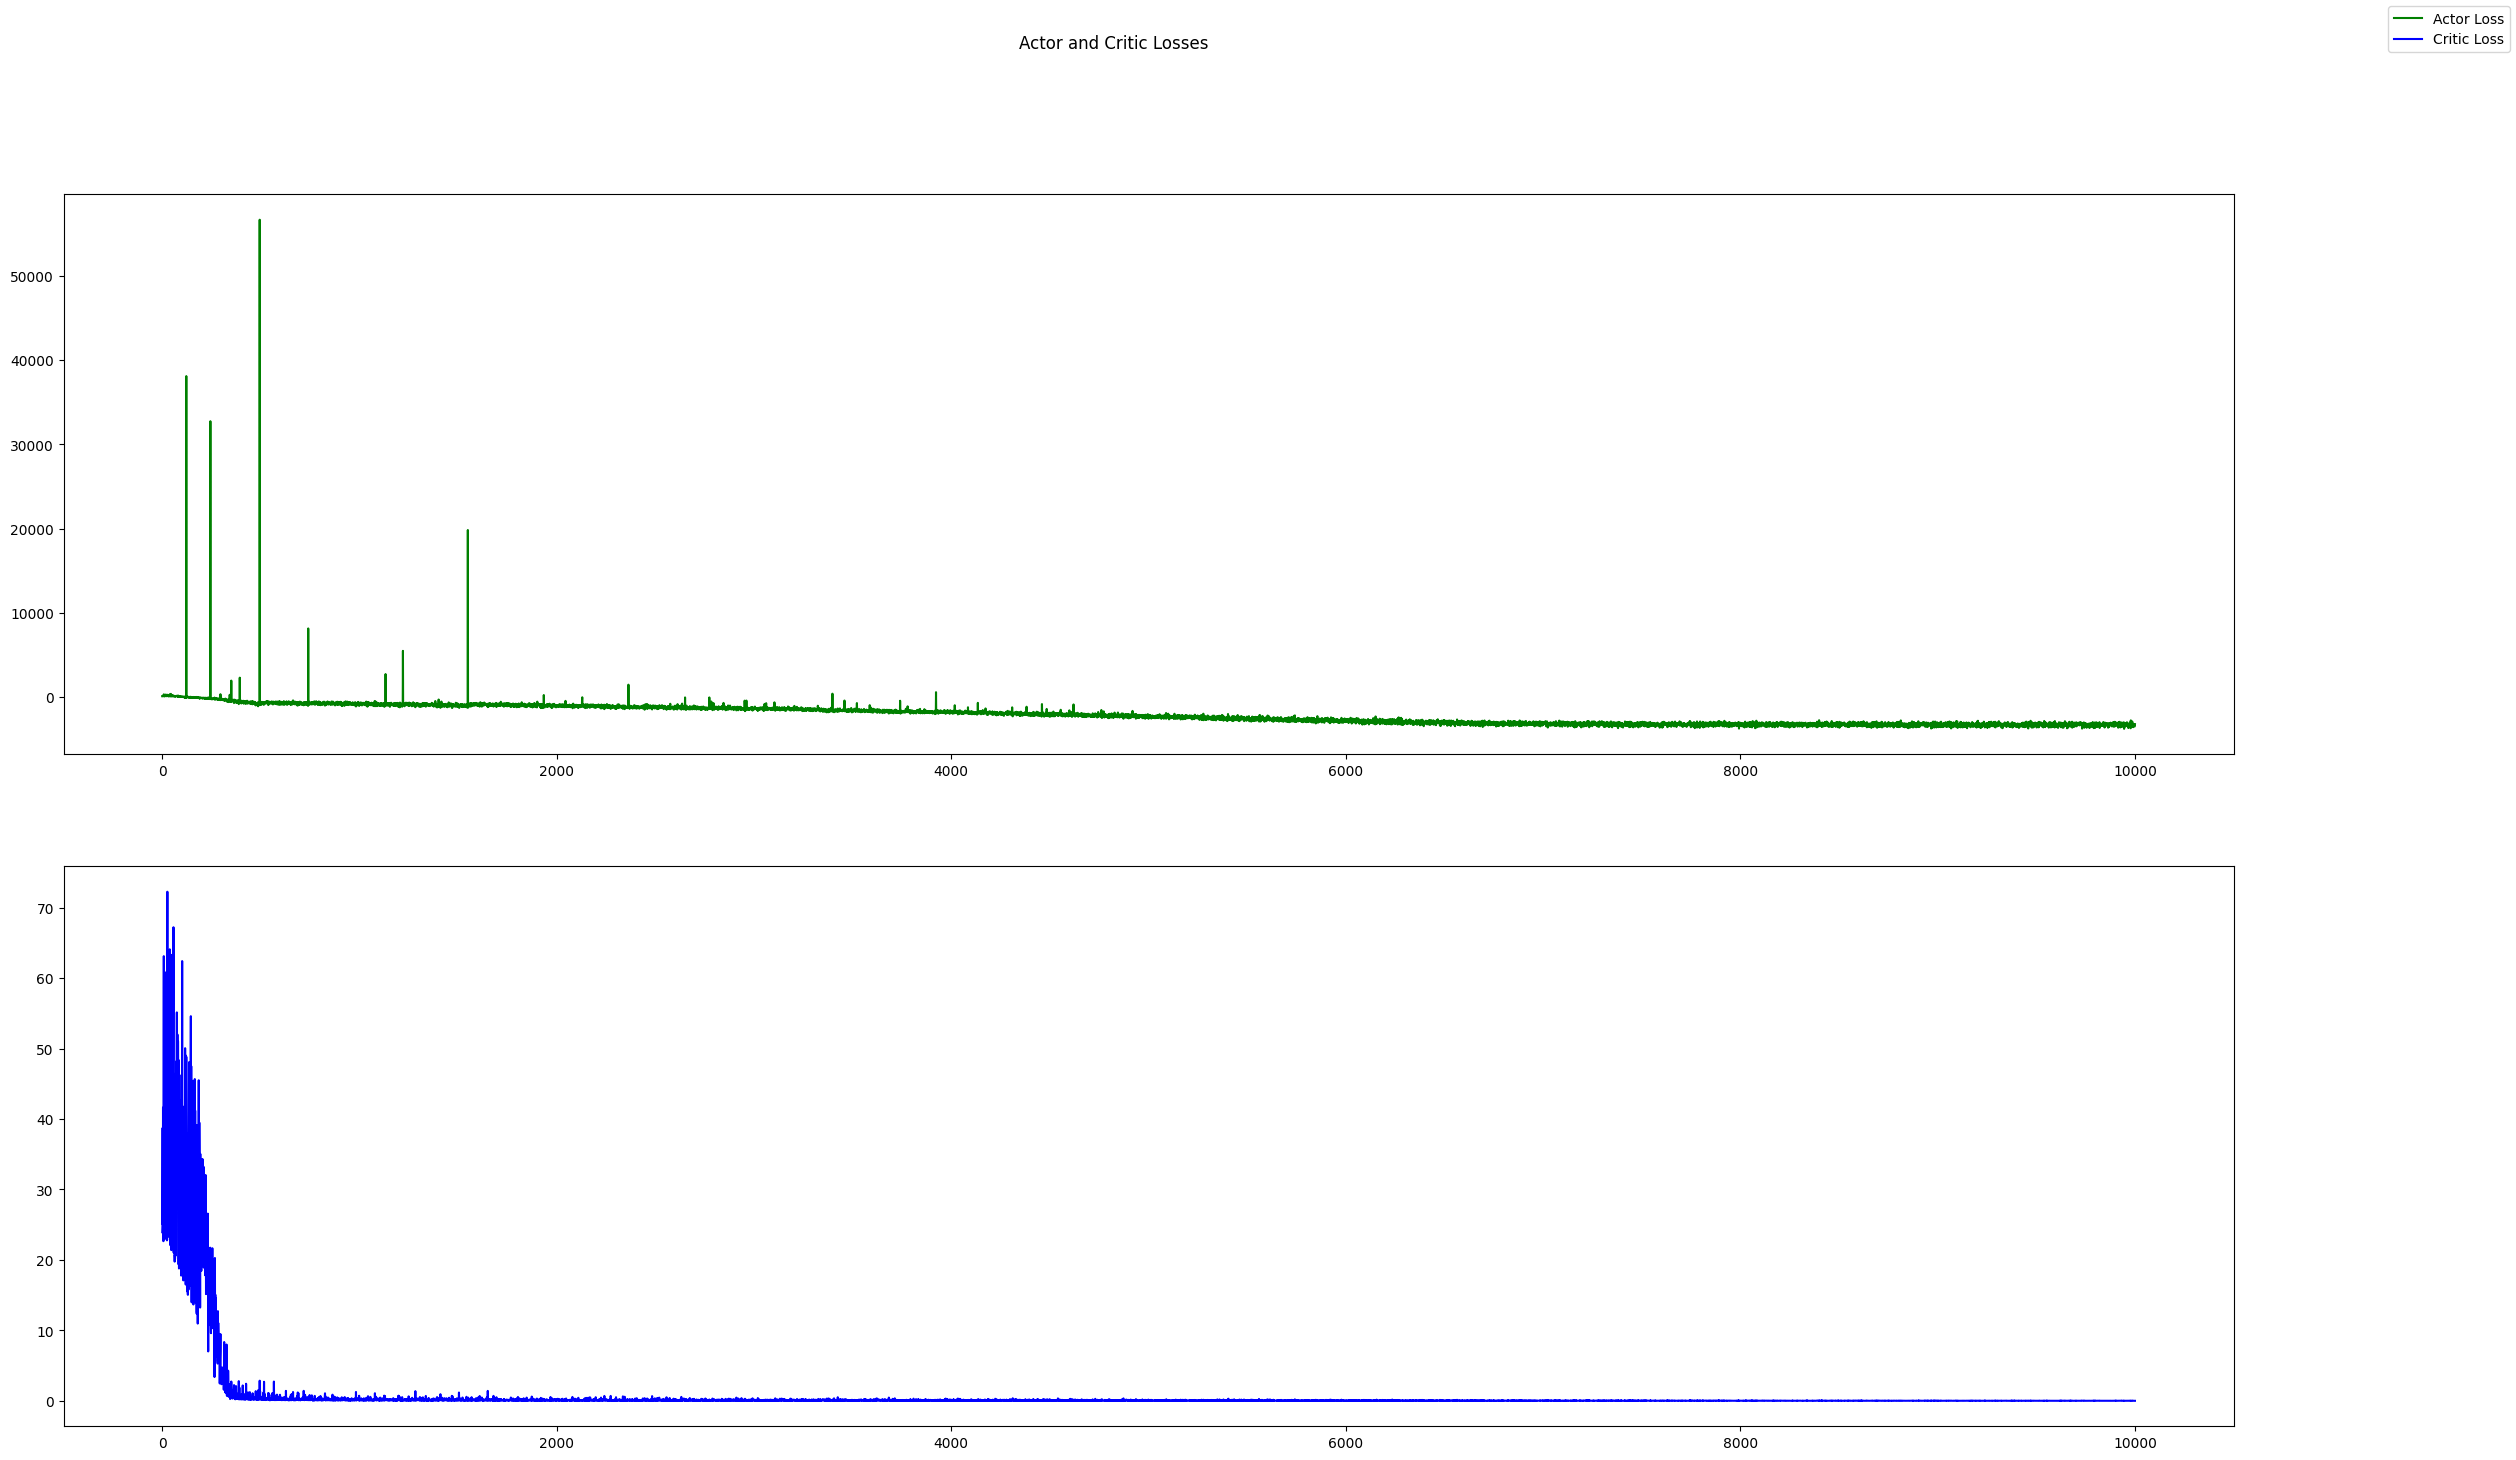

In [189]:
episodes = np.arange(1, agent.num_episodes + 1)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Actor and Critic Losses')

ax1.plot(episodes, act_losses, 'g', label='Actor Loss')

ax2.plot(episodes, crt_losses, 'b', label='Critic Loss')

fig.legend()
fig.set_figwidth(28)
fig.set_figheight(16)

In [204]:
Evaluate_Humanoid(agent, 10)

Reward episode 0: 4860
Reward episode 1: 4861
Reward episode 2: 4879
Reward episode 3: 4874
Reward episode 4: 4873
Reward episode 5: 4878
Reward episode 6: 4878
Reward episode 7: 4878
Reward episode 8: 4894
Reward episode 9: 4871
Mean Reward:  4875.026592721522


/home/brock/.local/lib/python3.10/site-packages/glfw/__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


In [214]:
Previous_Episodes(agent)

10
Reward at 0: 159
Reward at 1000: 262
Reward at 2000: 226
Reward at 3000: 212
Reward at 4000: 267
Reward at 5000: 249
Reward at 6000: 268
Reward at 7000: 268
Reward at 8000: 270
Reward at 9000: 251
